# Applies Deep Learning to ePodium dataset for prediction of Dyslexia.

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets

from functions import epodium, epodium_deep_learning, display_helper
from models.dnn import fully_connected_model
from models import transformer

import local_paths

2022-09-07 16:39:10.937697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 16:39:10.937731: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Choose which processed data to use

In [2]:
processing_method_widget = ipywidgets.RadioButtons(options=['autoreject', 'ransac'], 
                                                   value='autoreject', 
                                                   description='processing:')
display(processing_method_widget)

RadioButtons(description='processing:', options=('autoreject', 'ransac'), value='autoreject')

<br>

## Preparing data iterator (Sequence) as input to the deep learning models.
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

#### Split processed epochs* into train and test sequence.

*In the context of electroencephalography (EEG), *epochs* are EEG segments in which an event occurs. During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s. In the context of deep learning, *epochs* are iterations over the entire training dataset.

In [3]:
if(processing_method_widget.value == "autoreject"):
    path_processed = local_paths.ePod_processed_autoreject
if(processing_method_widget.value == "ransac"):
    path_processed = local_paths.ePod_processed_ransac

train, test = epodium_deep_learning.split_train_test_datasets(path_processed)
train_sequence = epodium_deep_learning.EvokedDataIterator(train, path_processed)
test_sequence = epodium_deep_learning.EvokedDataIterator(test, path_processed)

Analyzed: 228, bad: 42
186 files have enough epochs for analysis.
The dataset is split up into 138 train and 48 test experiments


#### Visualise data instance

In [4]:
x, y = train_sequence.__getitem__(0)
print(f"The shape of one data instance is {x[0].shape}")

The shape of one data instance is (32, 512)


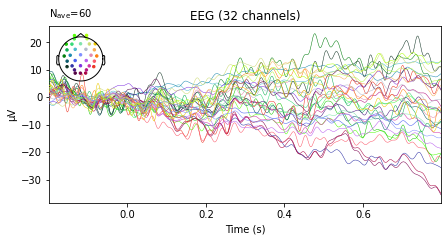

0: female,          1: risk,          1: deviant


In [5]:
index = 23 # 0 to 63

epodium.plot_array_as_evoked(x[index])

label_sex = 'male' if y[index][0] else 'female'
label_risk = 'risk' if y[index][1] else 'no risk'
label_event = 'deviant' if y[index][2] else 'standard'

print (f"{int(y[index][0])}: {label_sex}, \
         {int(y[index][1])}: {label_risk}, \
         {int(y[index][2])}: {label_event}")

<br>

## Deep Learning

The data is an *evoked* or *ERP* from a participant in the ePodium experiment. 60 EEG signals were averaged from -0.2 to +0.8 seconds after onset of an event. This is done for each of the 12 event types seperately.

__dimensions__: 
+ x (batches, timesteps, channels)
+ y (batches, labels)

__labels__: 
+ (Sex, At risk of dyslexia, first standard, standard, deviant)


#### Choose Deep Learning model

In [6]:
model_widget = ipywidgets.RadioButtons(options=['fully_connected', 'transformer', 'new_transformer'],
                                       value='fully_connected', 
                                       description='Models:')
display(model_widget)

RadioButtons(description='Models:', options=('fully_connected', 'transformer', 'new_transformer'), value='full…

#### Load model

In [7]:
# Paths to save model info
base_path = os.path.join(local_paths.models, model_widget.value)
path_history = base_path + "_history.npy"
path_model = base_path + "_model"
path_testset = base_path + "_testset.txt"
path_weights = base_path + "_weights.h5"

# Load Model
if(os.path.exists(path_model)):
    print(f"Loading Model: '{model_widget.value}'.\
          (If you want to train a new models, delete the old model first or choose another model name.)")
    
    # Loads the entire model from a folder:
    model = tf.keras.models.load_model(path_model)
    model.load_weights(path_weights)
    # Reads the test-set of the trained model and puts the experiment names into a list:
    testset = open(path_testset, "r").read().split()
    # Loads the training history dictionary:
    history = np.load(path_history, allow_pickle=True).item()
else: print("Model not found")

Model not found


<br>

## Analyzing trained models

#### Show Training History

In [8]:
display_helper.show_plot(x = range(len(history['loss'])), y = history['loss'] ,xlabel = "epochs", ylabel = "validation loss", title = "Loss during training")
display_helper.show_plot(x = range(len(history['loss'])), y = history['val_loss'] ,xlabel = "epochs", ylabel = "validation loss", title = "Validation loss during training")

NameError: name 'history' is not defined

#### Make predictions on test set

In [ ]:
# Loop over test_set, analyse each file x amount of time

for testfile in testset: 
    
    test_experiment = epodium_deep_learning.EvokedDataIterator([testfile], path_processed, n_experiments_batch = 8)

    index = 16
    x, y = test_experiment.__getitem__(0)
    epodium.plot_array_as_evoked(x[index])
    
    print(model.predict(x[index]))

    label_sex = 'male' if y[index][0] else 'female'
    label_risk = 'risk' if y[index][1] else 'no risk'
    label_event = 'deviant' if y[index][2] else 'standard'

    print (f"{int(y[index][0])}: {label_sex}, \
         {int(y[index][1])}: {label_risk}, \
         {int(y[index][2])}: {label_event}")
    
    break

    # Load 

In [ ]:
len(x)

In [ ]:
## TODO Choose model from all loaded models:

# path_models = glob.glob(os.path.join(local_paths.models, '*' + model_extension))
# models = []
# paths_model_file = []
# paths_model_history = []

# for path_model in path_models:
#     model_temp = os.path.splitext(path_model)[0]    
#     models.append(os.path.basename(model_temp))
#     paths_model_file.append(model_temp + model_extension)
#     paths_model_history.append(model_temp + '_history.npy')

# model = ipywidgets.Select(options=models, description='Models:')
# display(model)